## Imports

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
import torchvision.transforms as T
import os
from torch.optim.lr_scheduler import _LRScheduler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2 as cv
from skimage.measure import label
from IPython.display import clear_output

from models.vae import VAE
from models.base import Decoder, Encoder
from models.rhvae import RHVAE
from models.hvae import HVAE
import scipy.io as sio

print('imported')

imported


### Constants

In [25]:
np.random.seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

WEIGHTS_DIR = './weights'
if not os.path.exists(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

IMG_SIZE = (128, 128)
NUM_CHANNELS = 1
BATCH_SIZE = 64
EPOCHS = 5000
LEARNING_RATE = 0.001
LATENT_DIM = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device: {} ({})'.format(device, torch.cuda.get_device_name(device)))

Current device: cuda (NVIDIA RTX A6000)


## Loading data

### MNIST

In [35]:
# dans un premier lieu, nous allons travailler avec MNIST
mnist = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True)

n_samples = 1000

# removing some digits to reduce the size of the dataset
selected_index = np.isin(mnist.targets, [1, 2, 3])
images = mnist.data[selected_index][:n_samples]
targets = mnist.targets[selected_index][:n_samples]

# preprocessing
images = images.reshape(-1, 1, 28, 28)
# images = T.functional.resize(images, IMG_SIZE)
images = images.__div__(255).type(torch.float32)

train_x, test_x, train_y, test_y = train_test_split(images, targets, test_size=0.1, random_state=42)

train_loader = torch.utils.data.DataLoader(train_x, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_x, batch_size=BATCH_SIZE, shuffle=False)

print('Number of training samples: {}'.format(len(train_x)))
print('Number of test samples: {}'.format(len(test_x)))
print('Number of iterations per epoch: {}'.format(len(train_loader)))
print('Image size: {}'.format(train_x.shape))

Number of training samples: 900
Number of test samples: 100
Number of iterations per epoch: 15
Image size: torch.Size([900, 1, 28, 28])


### BraTS

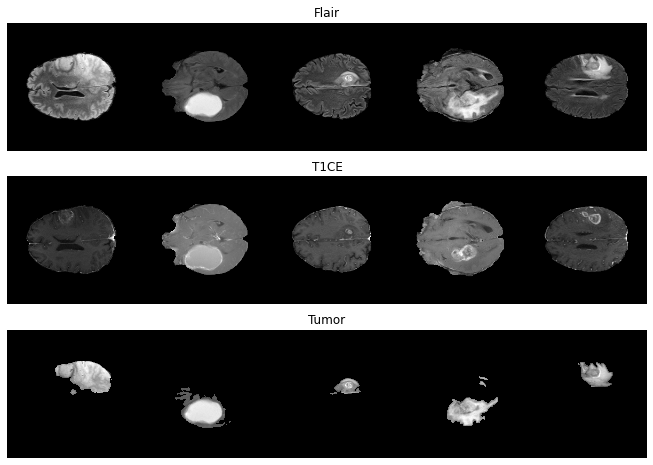

Number of train samples: 300
Number of test samples: 50
Image size: torch.Size([128, 128])
Total shape: torch.Size([300, 1, 128, 128])


In [26]:
# loading brats dataset
train, test = np.load('./data/brats_data.npz'), np.load('./data/brats_data_test.npz')
train_flair, train_t1ce, test_flair, test_t1ce = train['flair'], train['t1ce'], test['flair'], test['t1ce']
train_mask, test_mask = train['mask'], test['mask']

# turning the data into tensors
train_flair = torch.tensor(train_flair, dtype=torch.float32)
train_t1ce = torch.tensor(train_t1ce, dtype=torch.float32)
train_mask = torch.tensor(train_mask, dtype=torch.float32)
test_flair = torch.tensor(test_flair, dtype=torch.float32)
test_t1ce = torch.tensor(test_t1ce, dtype=torch.float32)
test_mask = torch.tensor(test_mask, dtype=torch.float32)

# resizing images
train_flair = T.functional.resize(train_flair, IMG_SIZE)
test_flair = T.functional.resize(test_flair, IMG_SIZE)
train_t1ce = T.functional.resize(train_t1ce, IMG_SIZE)
test_t1ce = T.functional.resize(test_t1ce, IMG_SIZE)
train_mask = T.functional.resize(train_mask, IMG_SIZE)
test_mask = T.functional.resize(test_mask, IMG_SIZE)

train_mask[train_mask > 0] = 1
test_mask[test_mask > 0] = 1

# extracted tumors from masks
train_tumor = train_mask * train_flair
test_tumor = test_mask * test_flair

# preprocessing
n_max_train_flair = [train_flair[i].max() for i in range(train_flair.shape[0])]
n_max_train_t1ce = [train_t1ce[i].max() for i in range(train_t1ce.shape[0])]
n_max_test_flair = [test_flair[i].max() for i in range(test_flair.shape[0])]
n_max_test_t1ce = [test_t1ce[i].max() for i in range(test_t1ce.shape[0])]
n_max_train_tumor = [train_tumor[i].max() for i in range(train_tumor.shape[0])]
n_max_test_tumor = [test_tumor[i].max() for i in range(test_tumor.shape[0])]

for idx in range(0, train_flair.shape[0]):
    train_flair[idx] = (train_flair[idx] / n_max_train_flair[idx])
    train_t1ce[idx] = (train_t1ce[idx] / n_max_train_t1ce[idx])
    train_tumor[idx] = (train_tumor[idx] / n_max_train_tumor[idx])

for idx in range(0, test_flair.shape[0]):
    test_flair[idx] = (test_flair[idx] / n_max_test_flair[idx])
    test_t1ce[idx] = (test_t1ce[idx] / n_max_test_t1ce[idx])
    test_tumor[idx] = (test_tumor[idx] / n_max_test_tumor[idx])

class BraTSDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

# visualizing a sample
n_to_visualize = 5
rand_idx = np.random.randint(0, test_flair.shape[0], n_to_visualize)

plt.figure(figsize=(20, 8))
plt.subplot(3, 1, 1)
plt.imshow(np.hstack([test_flair[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('Flair')
plt.axis('off')
plt.subplot(3, 1, 2)
plt.imshow(np.hstack([test_t1ce[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('T1CE')
plt.axis('off')
plt.subplot(3, 1, 3)
plt.imshow(np.hstack([test_tumor[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('Tumor')
plt.axis('off')

plt.show()

print('Number of train samples: {}'.format(train_flair.shape[0]))
print('Number of test samples: {}'.format(test_flair.shape[0]))
print('Image size: {}'.format(train_flair.shape[2:]))
print('Total shape: {}'.format(train_flair.shape))

## Utils

### Scheduler

In [17]:
class PolyScheduler(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_steps, warmup_steps, last_epoch=-1):
        self.base_lr = base_lr
        self.warmup_lr_init = 0.0001
        self.max_steps: int = max_steps
        self.warmup_steps: int = warmup_steps
        self.power = 2
        super(PolyScheduler, self).__init__(optimizer, -1, False)
        self.last_epoch = last_epoch

    def get_warmup_lr(self):
        alpha = float(self.last_epoch) / float(self.warmup_steps)
        return [self.base_lr * alpha for _ in self.optimizer.param_groups]

    def get_lr(self):
        if self.last_epoch == -1:
            return [self.warmup_lr_init for _ in self.optimizer.param_groups]
        if self.last_epoch < self.warmup_steps:
            return self.get_warmup_lr()
        else:
            alpha = pow(
                1
                - float(self.last_epoch - self.warmup_steps)
                / float(self.max_steps - self.warmup_steps),
                self.power,
            )
            return [self.base_lr * alpha for _ in self.optimizer.param_groups]

def mask_postprocessing(mask):
    labels = label(mask, connectivity=2)
    largest_label = np.argmax(np.bincount(labels.flat)[1:]) + 1
    mask = (labels == largest_label).astype(np.uint8)

    # dilation and erosion
    mask = cv.erode(mask, np.ones((3, 3), np.uint8), iterations=1)
    mask = cv.dilate(mask, np.ones((7, 7), np.uint8), iterations=1)
    return mask

### Plots

In [18]:
def plot(x, title, n_samples=5, figsize=(10, 2)):    
    plt.figure(figsize=figsize)
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(x[i] if n_samples > 1 else x, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

def plot_model_stats(model_name, train, test, metric_name, ylim=None, loc='upper right'):
    fig = plt.figure(figsize=(16, 5))
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(train)), train, label = 'Train {}'.format(metric_name))
    plt.plot(np.arange(len(test)), test, label = 'Val {}'.format(metric_name))
    if ylim != None:
        plt.ylim(ylim)
    plt.title('Model: {} - Validation loss: {:.4f}'.format(model_name, test[-1]))
    ax1.set_ylabel(metric_name)
    ax1.set_xlabel("Epochs")
    ax1.legend(loc=loc)
    plt.show()


# 0. Mask Generator

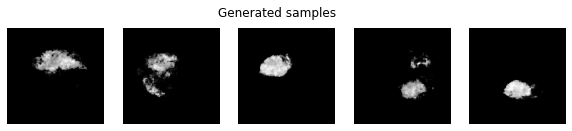

Epoch:  4977/5000 - Phase: train  - Total loss: 14.4966 - KL loss: 12.2317 - Recons loss: 2.2649: 100%|██████████| 5/5 [00:00<00:00, 10.40it/s]
Epoch:  4978/5000 - Phase: train  - Total loss: 14.6610 - KL loss: 12.2408 - Recons loss: 2.4202: 100%|██████████| 5/5 [00:00<00:00, 10.46it/s]
Epoch:  4979/5000 - Phase: train  - Total loss: 14.8714 - KL loss: 12.2073 - Recons loss: 2.6641: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]
Epoch:  4980/5000 - Phase: train  - Total loss: 14.5044 - KL loss: 12.2224 - Recons loss: 2.2820: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]
Epoch:  4981/5000 - Phase: train  - Total loss: 14.6884 - KL loss: 12.2340 - Recons loss: 2.4544: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]
Epoch:  4982/5000 - Phase: train  - Total loss: 14.4973 - KL loss: 12.2135 - Recons loss: 2.2838: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s]
Epoch:  4983/5000 - Phase: train  - Total loss: 14.7336 - KL loss: 12.2187 - Recons loss: 2.5149: 100%|██████████| 5/5 [00:00<00:00, 10.

Training over


In [19]:
verbose = True

mask_generator = VAE(
    input_shape=(1, *IMG_SIZE),
    out_channels=1,
    latent_dim=256,
    hidden_channels=[64, 128, 128, 256, 256],
    skip=False, device=device
).to(device)

# optimizer
optimizer = torch.optim.Adam(mask_generator.parameters(), lr=0.001, weight_decay=1e-6)

# data loader
# train_loader = torch.utils.data.DataLoader(BraTSDataset(train_flair, train_mask), batch_size=BATCH_SIZE, shuffle=True)
train_loader = torch.utils.data.DataLoader(BraTSDataset(train_tumor, train_tumor), batch_size=BATCH_SIZE, shuffle=True)

# scheduler
scheduler = PolyScheduler(optimizer, LEARNING_RATE, EPOCHS * len(train_loader), warmup_steps=len(train_loader), last_epoch=-1)

train_loss_history, test_loss_history = [], []
train_recon_history, test_recon_history = [], []

for epoch in range(EPOCHS):
    for phase in ['train']:# , 'val']:
        if phase == 'train':
            mask_generator.train()
            dataloader = train_loader
        else:
            mask_generator.eval()
            dataloader = test_loader

        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (_, mask) in enumerate(dataloader):
            mask = mask.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                recon_mask, z, eps, mu, log_var, _ = mask_generator(mask)
                # recon_mask = torch.sigmoid(recon_mask)
                loss, recon_loss, kl_loss = mask_generator.loss_function(recon_mask, mask, mu, log_var, beta=1.)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description(
                        'Epoch: {:5}/{} - Phase: {:6} - Total loss: {:.4f} - KL loss: {:.4f} - Recons loss: {:.4f}'
                        .format(
                            epoch + 1, EPOCHS, phase, running_loss / (i + 1), 
                            running_kl_loss / (i + 1), running_recon_loss / (i + 1)
                        )
                    )

        epoch_loss = running_loss / dataloader.__len__()
        epoch_recon_loss = running_recon_loss / dataloader.__len__()
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_recon_history.append(epoch_recon_loss)
        else:
            test_loss_history.append(epoch_loss)
            test_recon_history.append(epoch_recon_loss)

        if verbose: progress.close()
        del progress

        mask_generator.eval()
        if verbose and (epoch) % 25 == 0:
            clear_output(wait=True)
            n_samples = 5
            with torch.no_grad():
                generated = mask_generator.sample_img(n_samples=n_samples)
                plot(generated.cpu().squeeze(1), 'Generated samples', n_samples=n_samples, figsize=(10, 2))

print('Training over')

# 1. Conditional VAE

In [6]:
class CVAE(VAE):
    def __init__(self, input_shape, out_channels, latent_dim, mlp_ratio, hidden_channels, mask_hidden_channels, skip=True, device='cuda'):
        VAE.__init__(self, input_shape, out_channels, latent_dim, hidden_channels, skip, device)
        self.mask_encoder = Encoder((1, *input_shape[1:]), latent_dim, mask_hidden_channels)
        self.mask_encoder.log_var = nn.Identity()

        self.decoder.fully_connected = nn.Linear(latent_dim * 2, self.decoder.fully_connected.out_features)

        # self.fusion = nn.Sequential(
        #     nn.Linear(2 * latent_dim, int(2 * latent_dim * mlp_ratio)),
        #     nn.ReLU()
        # ).to(device)
        
        # self.mu_ = nn.Linear(int(2 * latent_dim * mlp_ratio), latent_dim).to(device)
        # self.log_var_ = nn.Linear(int(2 * latent_dim * mlp_ratio), latent_dim).to(device)

    def forward(self, x, mask):
        x = torch.cat([x, mask], dim=1)
        mu_x, log_var_x, _ = self.encoder(x)
        z_x = self.reparameterize(mu_x, log_var_x)
        
        z_mask, _, mask_features = self.mask_forward(mask)
        # z_mask = self.reparameterize(mu_mask, log_var_mask)

        z_f = torch.cat([z_x, z_mask], dim=1)

        # z_f = self.fusion(torch.cat([z_x, z_mask], dim=-1))
        # mu_f = self.mu_(z_f)
        # log_var_f = self.log_var_(z_f)
        # z_f = self.reparameterize(mu_f, log_var_f)
        
        # x_recon = self.decoder(z_f, mask_features)
        # return x_recon, z_f , mu_f, log_var_f
        x_recon = self.decoder(z_f, mask_features)
        return x_recon, z_f , mu_x, log_var_x

    def sample_from_mask(self, mask):
        z_mask, _, mask_features = self.mask_forward(mask)
        # z_mask = self.reparameterize(mu_mask, log_var_mask)
        z_x = self.normal.sample(sample_shape=(mask.shape[0],)).to(self.device)

        # z_f = self.fusion(torch.cat([z_x, z_mask], dim=-1))
        # mu_f = self.mu_(z_f)
        # log_var_f = self.log_var_(z_f)
        # z_f = self.reparameterize(mu_f, log_var_f)
        z_f = torch.cat([z_x, z_mask], dim=1)
        
        # x_recon = self.decoder(z_f, mask_features)
        x_recon = self.decoder(z_f, mask_features)
        return x_recon

    def mask_forward(self, mask):
        mu, log_var, features = self.mask_encoder(mask)
        return mu, log_var, features

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


In [ ]:
verbose = True
HIDDEN_CHANNELS = [64, 128, 128, 256, 256, 512]
MASK_HIDDEN_CHANNELS = [64, 128, 128, 256, 256, 512]

# model
model = CVAE(
    input_shape=(2, *IMG_SIZE),
    out_channels=NUM_CHANNELS,
    latent_dim=LATENT_DIM,
    mlp_ratio=0.8,
    hidden_channels=HIDDEN_CHANNELS,
    mask_hidden_channels=MASK_HIDDEN_CHANNELS,
    skip=True, device=device
).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

# data loader
# train_loader = torch.utils.data.DataLoader(BraTSDataset(train_flair, train_mask), batch_size=BATCH_SIZE, shuffle=True)
train_loader = torch.utils.data.DataLoader(BraTSDataset(train_flair, train_mask), batch_size=BATCH_SIZE, shuffle=True)

# scheduler
scheduler = PolyScheduler(optimizer, LEARNING_RATE, EPOCHS * len(train_loader), warmup_steps=len(train_loader), last_epoch=-1)

train_loss_history, test_loss_history = [], []
train_recon_history, test_recon_history = [], []

for epoch in range(EPOCHS):
    for phase in ['train']:# , 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (x, mask) in enumerate(dataloader):
            x, mask = x.to(device, dtype=torch.float32), mask.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                recon_x, z, mu, log_var = model(x, mask)
                loss, recon_loss, kl_loss = model.loss_function(recon_x, x, mu, log_var, beta=1.0)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description(
                        'Epoch: {:5}/{} - Phase: {:6} - Total loss: {:.4f} - KL loss: {:.4f} - Recons loss: {:.4f}'
                        .format(
                            epoch + 1, EPOCHS, phase, running_loss / (i + 1), 
                            running_kl_loss / (i + 1), running_recon_loss / (i + 1)
                        )
                    )

        epoch_loss = running_loss / dataloader.__len__()
        epoch_recon_loss = running_recon_loss / dataloader.__len__()
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_recon_history.append(epoch_recon_loss)
        else:
            test_loss_history.append(epoch_loss)
            test_recon_history.append(epoch_recon_loss)

        if verbose: progress.close()
        del progress

        model.eval()
        if verbose and (epoch) % 50 == 0:
            clear_output(wait=True)
            n_samples = 5
            with torch.no_grad():
                random_idx = np.random.randint(0, len(test_mask))
                random_mask = test_mask[random_idx].unsqueeze(0).repeat(n_samples, 1, 1, 1).to(device)
                generated = model.sample_from_mask(random_mask)
                plot(generated.detach().cpu().squeeze(1), 'Generated samples', n_samples=n_samples, figsize=(10, 2))
                plt.figure(figsize=(2, 2))
                plt.axis('off')
                plt.title('Mask GT')
                plt.imshow(random_mask[0].squeeze(0).cpu().numpy(), cmap='gray')
                plt.show()

print('Training over')

### Saving model

In [24]:
state_dict = {
    'class': 'CVAE',
    'input_shape': (2, *IMG_SIZE),
    'out_channels': NUM_CHANNELS,
    'latent_dim': LATENT_DIM,
    'hidden_channels': HIDDEN_CHANNELS,
    'mask_hidden_channels': MASK_HIDDEN_CHANNELS,
    'skip': False,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'train_loss_history': train_loss_history,
    'test_loss_history': test_loss_history
}

torch.save(state_dict, os.path.join(WEIGHTS_DIR, 'cvae_0.pth'))
print('model saved')

model saved


### Generating samples

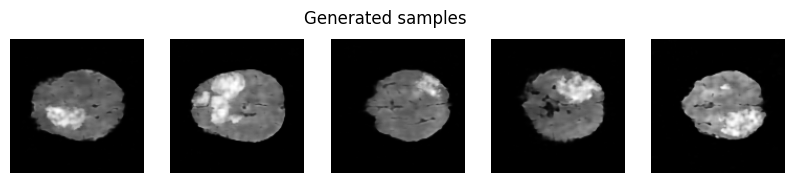

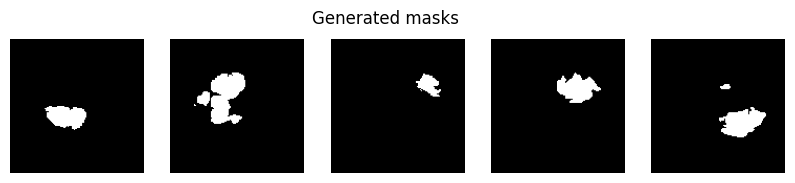

In [344]:
random_idx = np.random.randint(0, len(test_mask), 5)

# generated masks
# random_mask = mask_generator.sample_img(n_samples=5).detach().cpu()
# for idx, m in enumerate(random_mask):
#     random_mask[idx] = torch.tensor(mask_postprocessing(m.squeeze(0).numpy())).unsqueeze(0)
# random_mask = random_mask.to(device)

# test set masks
random_mask = test_mask[random_idx].to(device)

generated = model.sample_from_mask(random_mask)
plot(generated.detach().cpu().squeeze(1), 'Generated samples', n_samples=n_samples, figsize=(10, 2))
plot(random_mask.detach().cpu().squeeze(1), 'Generated masks', n_samples=n_samples, figsize=(10, 2))

# 2. Conditional HVAE

In [55]:
class HCVAE(HVAE):
    def __init__(self, input_shape, out_channels, latent_dim, hidden_channels, 
            mask_hidden_channels, n_lf=3, eps_lf=0.01, beta_zero=0.3, device='cuda'
        ):
        HVAE.__init__(self, input_shape, out_channels, latent_dim, hidden_channels, n_lf, eps_lf, beta_zero, False, device)
        self.mask_encoder = Encoder((1, *input_shape[1:]), latent_dim, mask_hidden_channels).to(device)

    def mask_forward(self, mask):
        mu, log_var, _ = self.mask_encoder(mask)
        z, std, eps = self.reparameterize(mu, log_var)
        return z, mu, log_var, std, eps
    
    def forward(self, x, mask):
        x_hat = torch.cat([x, mask], dim=1)
        mu_x, log_var_x, _ = self.encoder(x_hat)
        z_x, std_x, eps_x = self.reparameterize(mu_x, log_var_x)
        z_mask, mu_mask, log_var_mask, std_mask, eps_mask = self.mask_forward(mask)
        z0 = z_x
        recon_x = self.decoder(z0, None)
        gamma = torch.randn_like(z0, device=self.device)
        rho = gamma / self.beta_zero_sqrt
        z = z0
        beta_sqrt_old = self.beta_zero_sqrt

        for k in range(self.n_lf):
            U = -self.log_p_xz(recon_x, x, z).sum()
            g = grad(U, z, create_graph=True)[0]
            rho_ = rho - (self.eps_lf / 2) * g
            z = z + self.eps_lf * rho_ + z_mask
            recon_x = self.decoder(z, None)

            U = -self.log_p_xz(recon_x, x, z).sum()
            g = grad(U, z, create_graph=True)[0]
            rho__ = rho_ - (self.eps_lf / 2) * g

            beta_sqrt = self._tempering(k + 1, self.n_lf)
            rho = (beta_sqrt_old / beta_sqrt) * rho__
            beta_sqrt_old = beta_sqrt

        return recon_x, z + z_mask, z0, rho, eps_x + eps_mask, gamma, mu_x + mu_mask, log_var_x + log_var_mask

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std, std, eps


In [ ]:
verbose = True
HIDDEN_CHANNELS = [64, 128, 128, 256, 256, 512, 512]
MASK_HIDDEN_CHANNELS = [32, 64, 128, 128, 256, 256]

# model
model = HCVAE(
    input_shape=(2, *IMG_SIZE),
    out_channels=NUM_CHANNELS,
    latent_dim=LATENT_DIM,
    hidden_channels=HIDDEN_CHANNELS,
    mask_hidden_channels=MASK_HIDDEN_CHANNELS,
    device=device
).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

# data loader
# train_loader = torch.utils.data.DataLoader(BraTSDataset(train_flair, train_t1ce), batch_size=BATCH_SIZE, shuffle=True)
train_loader = torch.utils.data.DataLoader(BraTSDataset(test_flair, test_t1ce), batch_size=BATCH_SIZE, shuffle=False)

# scheduler
scheduler = PolyScheduler(optimizer, LEARNING_RATE, EPOCHS * len(train_loader), warmup_steps=len(train_loader), last_epoch=-1)

train_loss_history, test_loss_history = [], []

for epoch in range(EPOCHS):
    for phase in ['train']:#, 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (x, mask) in enumerate(dataloader):
            x, mask = x.to(device, dtype=torch.float32), mask.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                recon_x, z, z0, rho, eps, gamma, mu, log_var = model(x, mask)
                loss = model.loss_function(recon_x, x, z0, z, rho, eps, gamma, mu, log_var)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

            running_loss += loss.item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description(
                        'Epoch: {:5}/{} - Phase: {:6} - Total loss: {:.4f}'
                        .format(
                            epoch + 1, EPOCHS, phase, running_loss / (i + 1)
                        )
                    )

        epoch_loss = running_loss / dataloader.__len__()
        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            test_loss_history.append(epoch_loss)

        if verbose: progress.close()
        del progress

        model.eval()
        if verbose and (epoch) % 25 == 0:
            n_samples = 5
            with torch.no_grad():
                generated = model.sample_img(n_samples=n_samples)
                plot(generated.cpu().squeeze(1), 'Generated samples', n_samples=n_samples, figsize=(10, 2))

print('Training over')

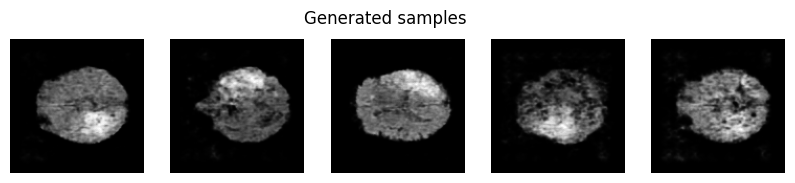

In [58]:
model.eval()
n_samples = 5
generated = model.sample_img(n_samples=n_samples)
plot(generated.detach().cpu().squeeze(1), 'Generated samples', n_samples=n_samples, figsize=(10, 2))

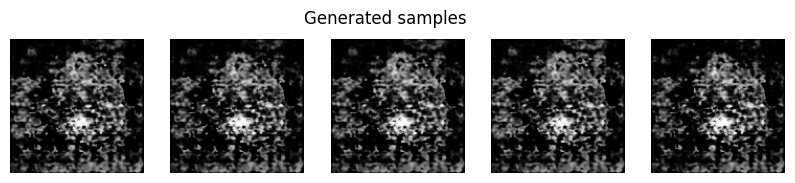

In [60]:
model.eval()
z = model.normal.sample(sample_shape=(n_samples,)).to(device)
z.requires_grad_(True)
random_mask = test_mask[1].unsqueeze(0).repeat(n_samples, 1, 1, 1).to(device)
z_mask, mu_mask, log_var_mask, _, _ = model.mask_forward(random_mask)
z = z + z_mask
generated = model.decoder(z, None)
plot(generated.detach().cpu().squeeze(1), 'Generated samples', n_samples=n_samples, figsize=(10, 2))

In [39]:
state_dict = {
    'class': 'HCVAE',
    'input_shape': (2, *IMG_SIZE),
    'out_channels': NUM_CHANNELS,
    'latent_dim': LATENT_DIM,
    'hidden_channels': HIDDEN_CHANNELS,
    'mask_hidden_channels': MASK_HIDDEN_CHANNELS,
    'skip': False,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'train_loss_history': train_loss_history,
    'test_loss_history': test_loss_history
}

torch.save(state_dict, os.path.join(WEIGHTS_DIR, 'hcvae_0.pth'))
print('model saved')

model saved


# --------------------------------------------------------------------------------------